In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#project_data = pd.read_csv('C:/Users/Ghans/Desktop/Workshop/train_data.csv')
#resource_data = pd.read_csv('C:/Users/Ghans/Desktop/Workshop/resources.csv')
project_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Archives/train_data.csv')
resource_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Archives/resources.csv')

In [0]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
#project_data = project_data.head(5000)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
#resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


## 1.2 preprocessing of `project_subject_categories`

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
import nltk
nltk.download('stopwords')
import pdb
preprocessed_essays = []
stop_words = set(stopwords.words('english'))
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    words = sent.split()
    new_words = []
    for word in words:
        #word1 = word
        word = word.lower()
        word = word.strip()
        if word not in stop_words:
            new_words.append(word)
    #pdb.set_trace()
    preprocessed_essays.append(" ".join(new_words))

  0%|          | 469/109248 [00:00<00:23, 4689.81it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 109248/109248 [00:22<00:00, 4785.13it/s]


<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [0]:
# similarly you can preprocess the titles also

#------------------------------ FOR TITLE ------------------------------------------------

from tqdm import tqdm
preprocessed_title = []

for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    words = sent.split()
    new_words = []
    for word in words:
        #word1 = word
        word = word.lower()
        word = word.strip()
        if word not in stop_words:
            new_words.append(word)
    #pdb.set_trace()
    preprocessed_title.append(" ".join(new_words))

100%|██████████| 109248/109248 [00:01<00:00, 63145.96it/s]


## 1.5 Preparing data for models

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [0]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
categories_one_hot = vectorizer.fit_transform(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [0]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot = vectorizer.fit_transform(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


### 1.5.4 Preparing DataFrame from all the above features

In [0]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

project_transformed_data = pd.DataFrame(data = {'quantity':pd.Series(project_data['quantity']),
                          'no_project':pd.Series(project_data['teacher_number_of_previously_posted_projects']),
                          'price':pd.Series(project_data['price']),
                          'preprocessed_essays':pd.Series(preprocessed_essays),
                          'preprocessed_title':pd.Series(preprocessed_title),
                          'school_state':project_data['school_state'],
                          'project_grade_category':project_data['project_grade_category'],
                          'teacher_prefix':project_data['teacher_prefix']
                         })

project_transformed_data.shape

(109248, 8)

__ Computing Sentiment Scores__

In [0]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

neg = []
neu = []
pos = []
compound = []
for essay in tqdm(project_data['essay'].values) : 
  ss = sid.polarity_scores(essay)
  neg.append(ss['neg'])
  neu.append(ss['neu'])
  pos.append(ss['pos'])
  compound.append(ss['compound'])


#counting number of words in title
words_in_title = []
for title in tqdm(project_data['project_title'].values):
  words_in_title.append(len(title))
  
#counting number of words in essays
words_in_essay = []
for essay in tqdm(project_data['essay'].values) :
  words_in_essay.append(len(essay))

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93'''

  0%|          | 0/109248 [00:00<?, ?it/s]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


100%|██████████| 109248/109248 [00:00<00:00, 1426945.54it/s]


In [0]:
# Preparing SET 5
set5 = pd.DataFrame(data = {'quantity':pd.Series(project_data['quantity']),
                          'no_project':pd.Series(project_data['teacher_number_of_previously_posted_projects']),
                          'price':pd.Series(project_data['price']),
                          'words_in_title': pd.Series(words_in_title),
                          'words_in_essay':pd.Series(words_in_essay),
                          'school_state':project_data['school_state'],
                          'project_grade_category':project_data['project_grade_category'],
                          'teacher_prefix':project_data['teacher_prefix'],
                          'neg':pd.Series(neg),
                          'neu':pd.Series(neu),
                          'pos':pd.Series(pos),
                          'compound':pd.Series(compound)
                         })

### Assignment 5: SVM

<h1>2. SVM </h1>

<ol>
    <li><strong>[Task-1] Apply Support Vector Machines(SGDClassifier with hinge loss: Linear SVM) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning
        </ul>
            </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply the Support Vector Machines on these features by finding the best hyper paramter as suggested in step 2 and step 3</strong>
        <ul>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
                <li><strong>Apply <a href='http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html'>TruncatedSVD</a> on <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a> of essay text, choose the number of components (`n_components`) using <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/pca-code-example-using-non-visualization/'>elbow method</a></strong> : numerical data</li>
            </ul>
         <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

###<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [0]:
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn import model_selection

_,_test,approval_,approval_test = model_selection.train_test_split(project_transformed_data,project_data['project_is_approved'],test_size=0.3,stratify=project_data['project_is_approved'])
_tr,_cv,approval_tr,approval_cv = model_selection.train_test_split( _,approval_,test_size=0.3,stratify=approval_)

#--------------------------------------------

text_tr = _tr['preprocessed_essays']
text_cv = _cv['preprocessed_essays']
text_test = _test['preprocessed_essays']

#---------------------------------------------

title_tr = _tr['preprocessed_title']
title_cv = _cv['preprocessed_title']
title_test = _test['preprocessed_title']

#----------------------------------------------

In [0]:
#spliting for set5
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn import model_selection

_,set5_test,approval_set5,approval_test_set5 = model_selection.train_test_split(set5,project_data['project_is_approved'],test_size=0.3,stratify=project_data['project_is_approved'])
set5_tr,set5_cv,approval_tr_set5,approval_cv_set5 = model_selection.train_test_split( _,approval_set5,test_size=0.3,stratify=approval_set5)

####<h2>2.2 Make Data Model Ready: encoding eassay, and project_title</h2>

###Encoding and vectorizing text features.

In [0]:
#============================================ BOW VECTORIZING =====================================

count_vectorizer = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))

text_tr_bow = count_vectorizer.fit_transform(text_tr)
text_cv_bow = count_vectorizer.transform(text_cv)
text_test_bow = count_vectorizer.transform(text_test)



#------------------------------------------------- For title --------------------------------

count_vectorizer1 = CountVectorizer(min_df=10)

title_tr_bow = count_vectorizer1.fit_transform(title_tr)
title_cv_bow = count_vectorizer1.transform(title_cv)
title_test_bow = count_vectorizer1.transform(title_test)


#================================================ TFIDF VECTORIZING ===========================

tfidf_vectorizer = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))

tfidf_text_tr_bow = tfidf_vectorizer.fit_transform(text_tr)
tfidf_text_cv_bow = tfidf_vectorizer.transform(text_cv)
tfidf_text_test_bow = tfidf_vectorizer.transform(text_test)


#------------------------------------------------- For title --------------------------------

tfidf_vectorizer1 = TfidfVectorizer(min_df=10)

tfidf_title_tr_bow = tfidf_vectorizer1.fit_transform(title_tr)
tfidf_title_cv_bow = tfidf_vectorizer1.transform(title_cv)
tfidf_title_test_bow = tfidf_vectorizer1.transform(title_test)


### W2V and TFIDF W2V Vectorizing.

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/Archives/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
# ================================================= Text AVGW2V Vectorizing ===============================================
# average Word2Vec
# compute average word2vec for each review.
text_tr_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_tr): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    text_tr_avg_w2v_vectors.append(vector)
    
#---------------------------------- For text CV ---------------------------------
text_cv_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    text_cv_avg_w2v_vectors.append(vector)
    
#---------------------------------- For text test ---------------------------------
text_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    text_test_avg_w2v_vectors.append(vector)
    
    
# ====================================================== TITLE AVGW2V VECTORIZING ====================================

#==========================================For title ======================================
title_tr_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_tr): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_tr_avg_w2v_vectors.append(vector)
    
#---------------------------------- For title CV ---------------------------------
title_cv_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_cv_avg_w2v_vectors.append(vector)
    
#---------------------------------- For title test ---------------------------------
title_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_test_avg_w2v_vectors.append(vector)

100%|██████████| 32775/32775 [00:00<00:00, 72298.74it/s]


In [0]:

# =================================================== TEXT TFIDF W2V VECTORIZING ===========================

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(text_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

text_tr_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_tr): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    text_tr_tfidf_w2v_vectors.append(vector)

#----------------------------------------- FOR TEXT CV ------------------------


# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

text_cv_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    text_cv_tfidf_w2v_vectors.append(vector)

#----------------------------------------- FOR TEXT TRAIN ------------------------

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

text_test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    text_test_tfidf_w2v_vectors.append(vector)

    
# ================================================ TITLE TFIDF W2V VECTORIZING =====================================

tfidf_model = TfidfVectorizer()
tfidf_model.fit(title_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

title_tr_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_tr): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tr_tfidf_w2v_vectors.append(vector)

#----------------------------------------- FOR TITLE CV ------------------------


# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

title_cv_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_cv_tfidf_w2v_vectors.append(vector)

#----------------------------------------- FOR TITLE TRAIN ------------------------
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

title_test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_test_tfidf_w2v_vectors.append(vector)

100%|██████████| 32775/32775 [00:00<00:00, 36892.70it/s]


In [0]:
tfidf_text_tr_bow.shape[1]

5000

###<H3> Applying TruncatedSVD to TFIDF features </H3>

In [0]:
'''# I don't know how to use sklearns's inbuilt elbow method with TruncatedSVD.
# So, I have written my own for loop.
# please correct me if I am wrong.
from sklearn.decomposition import TruncatedSVD
# Calculating variance for each component
variance_explained= TruncatedSVD(n_components = tfidf_text_tr_bow.shape[1]-1).fit(tfidf_text_tr_bow).explained_variance_ 
comp_var = {}
# Adding Variance of each component to make cummilative graph. 
for i in range(4999):
  comp_var[i] = sum(variance_explained[:i])
plt.plot(comp_var.keys(),comp_var.values())
plt.xlabel('Components')
plt.ylabel('Varience')
plt.title('Variance Explained')'''

KeyboardInterrupt: ignored

In [0]:
'''del comp_var
del variance_explained
print('As 3000 features explains more that 80% of the variance, We will choose n_components = 3000')

svd = TruncatedSVD(n_components = 2500)
reduced_text_tr =svd.fit_transform(tfidf_text_tr_bow)
reduced_text_cv =svd.transform(tfidf_text_cv_bow)
reduced_text_test =svd.transform(tfidf_text_test_bow)'''


In [0]:
'''set5_tr = pd.concat([set5_tr,pd.DataFrame(data = reduced_text_tr,index = set5_tr.index)],axis=1)
set5_cv = pd.concat([set5_cv,pd.DataFrame(data = reduced_text_cv,index = set5_cv.index)],axis=1)
set5_test = pd.concat([set5_test,pd.DataFrame(data = reduced_text_test,index = set5_test.index)],axis=1)'''

###<h3> Encoding and vectorizing numrical features


In [0]:
# transforming numrical data.
for feature in ['price','quantity','no_project']:
  scalar = StandardScaler()
  _tr[feature] = scalar.fit_transform(np.array(_tr[feature]).reshape(-1, 1))
  _cv[feature] = scalar.transform(np.array(_cv[feature]).reshape(-1, 1))
  _test[feature] = scalar.transform(np.array(_test[feature]).reshape(-1, 1))


#------------------------------------------- Set 5 -------------------------------------------------

'''for feature in ['price','quantity','no_project','words_in_title','words_in_essay','neg','neu','pos','compound']:
  scalar = StandardScaler()
  set5_tr[feature] = scalar.fit_transform(np.array(set5_tr[feature]).reshape(-1, 1))
  set5_cv[feature] = scalar.transform(np.array(set5_cv[feature]).reshape(-1, 1))
  set5_test[feature] = scalar.transform(np.array(set5_test[feature]).reshape(-1, 1))
  '''

"for feature in ['price','quantity','no_project','words_in_title','words_in_essay','neg','neu','pos','compound']:\n  scalar = StandardScaler()\n  set5_tr[feature] = scalar.fit_transform(np.array(set5_tr[feature]).reshape(-1, 1))\n  set5_cv[feature] = scalar.transform(np.array(set5_cv[feature]).reshape(-1, 1))\n  set5_test[feature] = scalar.transform(np.array(set5_test[feature]).reshape(-1, 1))\n  "

### Encoding and vectorizing categorical **features**

In [0]:
# transforming categorical data

#--------------------------For States -----------------------------------
state = set()
for state_ in _tr['school_state']:
    state.add(state_)

state_vectorizer = CountVectorizer(vocabulary = list(state),lowercase  = False)
tr_school_state = state_vectorizer.fit_transform(_tr['school_state'].values)
cv_school_state = state_vectorizer.transform(_cv['school_state'].values)
test_school_state = state_vectorizer.transform(_test['school_state'].values)

#------------------------For Grade -------------------------------------
grade_vectorizer = CountVectorizer(vocabulary = [ 'Grades PreK-2',
    'Grades 3-5',
    'Grades 6-8',
    'Grades 9-12'],lowercase  = False)
tr_grade_one_hot = grade_vectorizer.fit_transform(_tr['project_grade_category'].values)
cv_grade_one_hot = grade_vectorizer.transform(_cv['project_grade_category'].values)
test_grade_one_hot = grade_vectorizer.transform(_test['project_grade_category'].values)

#-----------------------For Prefix --------------------------------------

_tr['teacher_prefix'].fillna("missing_value", inplace = True)
_cv['teacher_prefix'].fillna("missing_value", inplace = True) 
_test['teacher_prefix'].fillna("missing_value", inplace = True) 

prefix_vectorizer = CountVectorizer(vocabulary = [ 'missing_value',
    'Dr.',
    'Mr.',
    'Mrs.',
    'Ms.',
    'Teacher.'],lowercase  = False)
tr_teacher_prefix = prefix_vectorizer.fit_transform(_tr['teacher_prefix'])
cv_teacher_prefix = prefix_vectorizer.transform(_cv['teacher_prefix'])
test_teacher_prefix = prefix_vectorizer.transform(_test['teacher_prefix'])

#---------------------------------------- Combining  Catogorical features with datasets--------------------------------------------------------------
_tr = pd.concat([_tr,
                 pd.DataFrame(data = tr_school_state.toarray(),index = _tr.index),
                 pd.DataFrame(data = tr_grade_one_hot.toarray(),index = _tr.index),
                 pd.DataFrame(data = tr_teacher_prefix.toarray(),index = _tr.index)],axis=1)

_cv = pd.concat([_cv,
                 pd.DataFrame(data = cv_school_state.toarray(),index = _cv.index),
                 pd.DataFrame(data = cv_grade_one_hot.toarray(),index = _cv.index),
                 pd.DataFrame(data = cv_teacher_prefix.toarray(),index = _cv.index)],axis=1)

_test = pd.concat([_test,
                 pd.DataFrame(data = test_school_state.toarray(),index = _test.index),
                 pd.DataFrame(data = test_grade_one_hot.toarray(),index = _test.index),
                 pd.DataFrame(data = test_teacher_prefix.toarray(),index = _test.index)],axis=1)

###<h3>Transforming categorical data for Set 5</h3>

In [0]:
'''# transforming categorical data for dataset 5
from scipy.sparse import csr_matrix
#--------------------------For States -----------------------------------
state = set()
for state_ in set5_tr['school_state']:
    state.add(state_)

state_vectorizer = CountVectorizer(vocabulary = list(state),lowercase  = False)
tr_school_state = state_vectorizer.fit_transform(set5_tr['school_state'].values)
cv_school_state = state_vectorizer.transform(set5_cv['school_state'].values)
test_school_state = state_vectorizer.transform(set5_test['school_state'].values)

#------------------------For Grade -------------------------------------
grade_vectorizer = CountVectorizer(vocabulary = [ 'Grades PreK-2',
    'Grades 3-5',
    'Grades 6-8',
    'Grades 9-12'],lowercase  = False)
tr_grade_one_hot = grade_vectorizer.fit_transform(set5_tr['project_grade_category'].values)
cv_grade_one_hot = grade_vectorizer.transform(set5_cv['project_grade_category'].values)
test_grade_one_hot = grade_vectorizer.transform(set5_test['project_grade_category'].values)

#-----------------------For Prefix --------------------------------------

set5_tr['teacher_prefix'].fillna("missing_value", inplace = True)
set5_cv['teacher_prefix'].fillna("missing_value", inplace = True) 
set5_test['teacher_prefix'].fillna("missing_value", inplace = True) 

prefix_vectorizer = CountVectorizer(vocabulary = [ 'missing_value',
    'Dr.',
    'Mr.',
    'Mrs.',
    'Ms.',
    'Teacher.'],lowercase  = False)
tr_teacher_prefix = prefix_vectorizer.fit_transform(set5_tr['teacher_prefix'])
cv_teacher_prefix = prefix_vectorizer.transform(set5_cv['teacher_prefix'])
test_teacher_prefix = prefix_vectorizer.transform(set5_test['teacher_prefix'])

#---------------------------------------- Combining  Catogorical features with datasets-------------------------------------------------------------

set5_tr.drop(['teacher_prefix','school_state','project_grade_category'],axis=1,inplace = True)
set5_cv.drop(['teacher_prefix','school_state','project_grade_category'],axis=1,inplace = True)
set5_test.drop(['teacher_prefix','school_state','project_grade_category'],axis=1,inplace = True)

set5_tr = csr_matrix(pd.concat([set5_tr,
                 pd.DataFrame(data = tr_school_state.toarray(),index = set5_tr.index),
                 pd.DataFrame(data = tr_grade_one_hot.toarray(),index = set5_tr.index),
                 pd.DataFrame(data = tr_teacher_prefix.toarray(),index = set5_tr.index)],axis=1).values)

set5_cv = csr_matrix(pd.concat([set5_cv,
                 pd.DataFrame(data = cv_school_state.toarray(),index = set5_cv.index),
                 pd.DataFrame(data = cv_grade_one_hot.toarray(),index = set5_cv.index),
                 pd.DataFrame(data = cv_teacher_prefix.toarray(),index = set5_cv.index)],axis=1).values)

set5_test = csr_matrix(pd.concat([set5_test,
                 pd.DataFrame(data = test_school_state.toarray(),index = set5_test.index),
                 pd.DataFrame(data = test_grade_one_hot.toarray(),index = set5_test.index),
                 pd.DataFrame(data = test_teacher_prefix.toarray(),index = set5_test.index)],axis=1).values)'''

In [0]:
'''set5_tr'''

###<h2>2.3 Make Data Model Ready: Integrating numerical, categorical and text features</h2>

In [0]:
'''columns = ['preprocessed_essays','preprocessed_title','teacher_prefix','school_state','project_grade_category']
_tr = _tr.drop(columns,axis = 1)
_cv = _cv.drop(columns,axis = 1)
_test = _test.drop(columns,axis = 1)'''

# Creating sparse matrix of numrical and categorical features
from scipy.sparse import csr_matrix

tr_csr_matrix = csr_matrix(_tr.values)
cv_csr_matrix = csr_matrix(_cv.values)
test_csr_matrix = csr_matrix(_test.values)

# Merging text features with numrical and categorical features

#========================================= For Set1 ==========================================
from scipy.sparse import hstack
set1_tr = hstack(( tr_csr_matrix,text_tr_bow,title_tr_bow))

#-------------------------------------------- SET 1 CV ----------------------------------------

set1_cv = hstack(( cv_csr_matrix,text_cv_bow,title_cv_bow))

#--------------------------------------- SET 1 TEST --------------------------------------------

set1_test = hstack((test_csr_matrix,text_test_bow,title_test_bow))


#======================================== For Set 2 =============================================

set2_tr = hstack((tr_csr_matrix,tfidf_text_tr_bow,tfidf_title_tr_bow))

#-------------------------------------------- SET 2 CV ----------------------------------------

set2_cv = hstack((cv_csr_matrix,tfidf_text_cv_bow,tfidf_title_cv_bow))

#--------------------------------------- SET 2 TEST --------------------------------------------

set2_test = hstack((test_csr_matrix,tfidf_text_test_bow,tfidf_title_test_bow))


#========================================= For Set3 ==========================================

#------------------------------------------- Set 3 TRAIN -----------------------------

set3_tr = hstack((tr_csr_matrix,text_tr_avg_w2v_vectors,title_tr_avg_w2v_vectors))

#-------------------------------------------- SET 3 CV ---------------------------------

set3_cv = hstack((cv_csr_matrix,text_cv_avg_w2v_vectors,title_cv_avg_w2v_vectors))

#-------------------------------------------- SET 3 TEST ---------------------------------

set3_test = hstack((test_csr_matrix,text_test_avg_w2v_vectors,title_test_avg_w2v_vectors))

#========================================= For Set4 ==========================================

#------------------------------------------- Set 4 TRAIN -----------------------------

set4_tr = hstack((tr_csr_matrix,text_tr_tfidf_w2v_vectors,title_tr_tfidf_w2v_vectors))

#-------------------------------------------- SET 4 CV ---------------------------------

set4_cv = hstack((cv_csr_matrix,text_cv_tfidf_w2v_vectors,title_cv_tfidf_w2v_vectors))

#-------------------------------------------- SET 4 TEST ---------------------------------

set4_test = hstack(( test_csr_matrix,text_test_tfidf_w2v_vectors,title_test_tfidf_w2v_vectors))


###<h3> Code for confusion Matrix </h3>

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

####<h2>2.4 Appling Logistic Regression on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Logistic Regression on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

###SET1

Max accuracy is for Alpha =  0.01

****Test accuracy for set1 is 74%


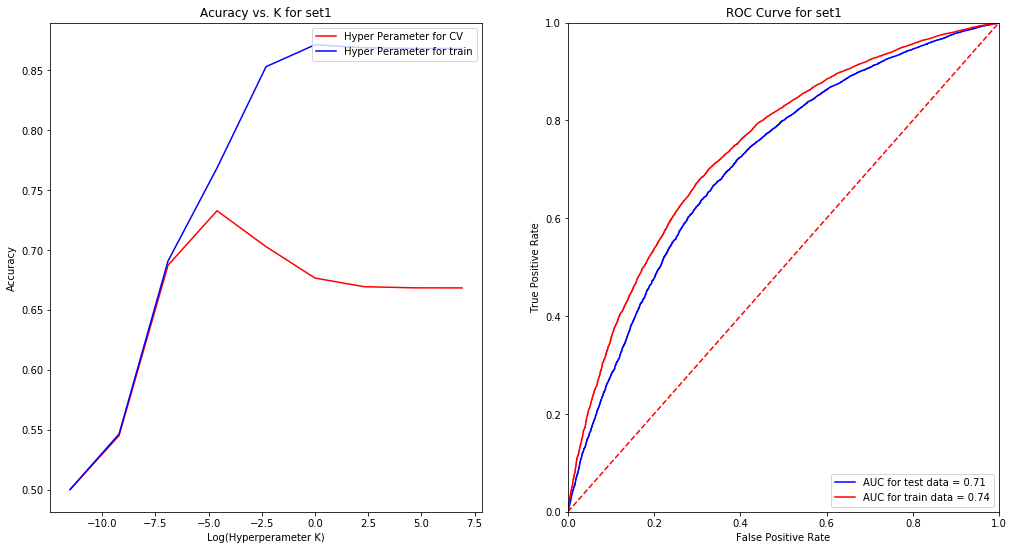

Traning Data


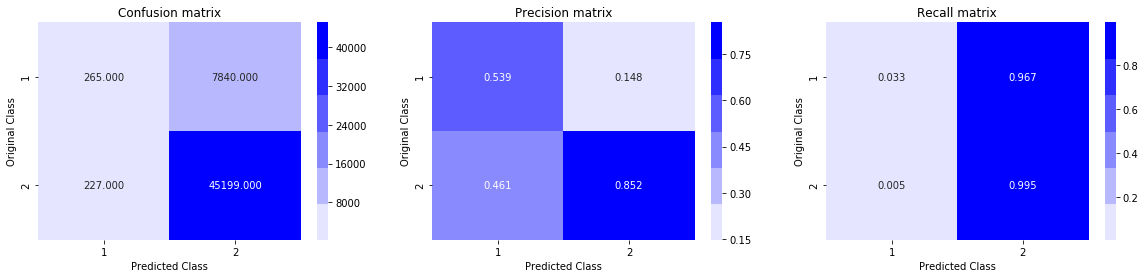

Test Data


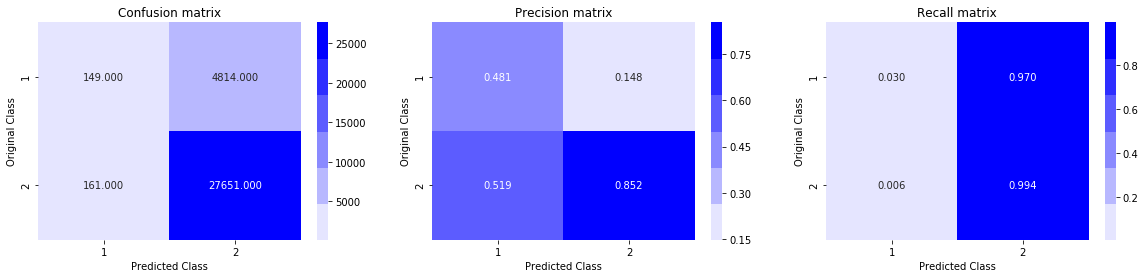

In [0]:
# Please write all the code with proper documentation
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set1')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set1')
# --------------------------------------------- Simple Cross validation ---------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]:
    SVM = CalibratedClassifierCV(LinearSVC(penalty = 'l1', C = i,class_weight="balanced",max_iter = 2000,dual=False))
    SVM.fit(set1_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set1_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set1_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(LinearSVC(penalty = 'l1', C = alpha_with_maximum_accuracy,max_iter = 2000,dual=False))
SVM.fit(set1_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set1_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set1_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set1 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# --------------------------------------------- Acuracy VS. K graph ---------------------------------------------
from math import log
plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set1')
plt.legend(loc = 'upper right')

# --------------------------------------------- AUC Curve For Test data ---------------------------------------------

#https://stackoverflow.com/a/52910821/7218422

#------------------------------------ For test data ------------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set1_test)
pred_test = SVM.predict(set1_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set1')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

------------------------------ With L2 Regularization ------------------------------
Max accuracy is for Alpha =  0.0001

****Test accuracy for set1 is 74%


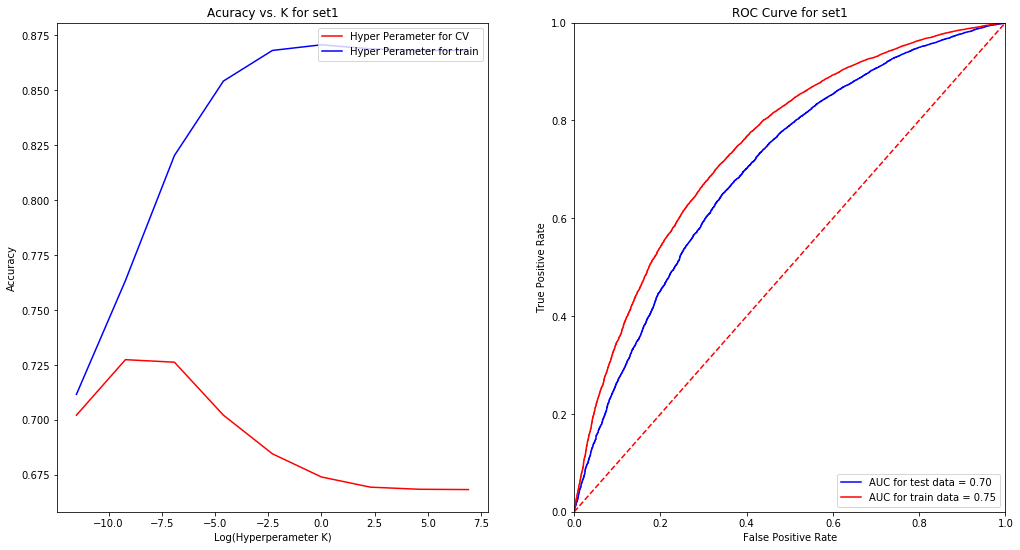

Traning Data


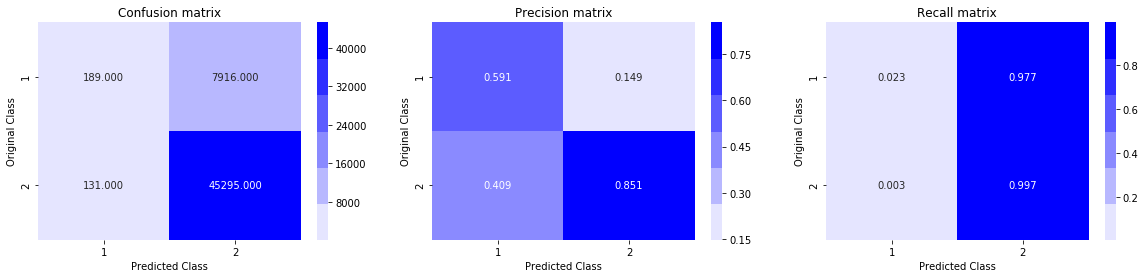

Test Data


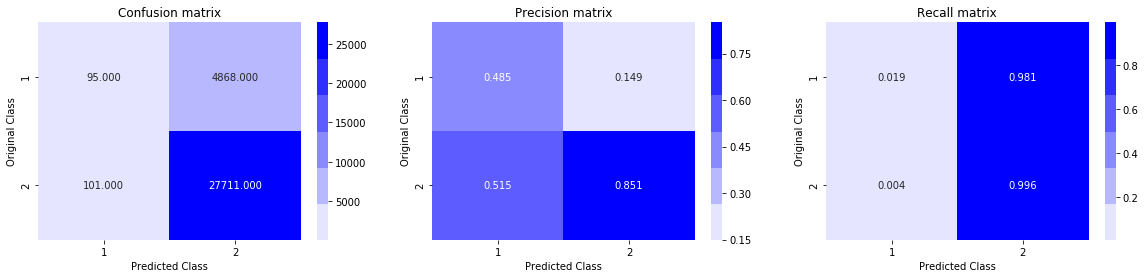

In [0]:
#======================================= L2 Regularization ===============================================

print('-'*30,'With L2 Regularization','-'*30)

#======================================= L2 Regularization ===============================================

# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set1')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set1')

# --------------------------------------- Simple Cross validation ------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]:
    SVM = CalibratedClassifierCV(LinearSVC(penalty = 'l2', C = i,class_weight="balanced",max_iter = 2000,dual=False))
    SVM.fit(set1_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set1_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set1_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(LinearSVC(penalty = 'l2', C = alpha_with_maximum_accuracy,max_iter = 2000,dual=False))
SVM.fit(set1_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set1_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set1_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set1 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# ---------------------------------------- Acuracy VS. K graph ---------------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set1')
plt.legend(loc = 'upper right')

# ----------------------------------------- AUC Curve For Test data -----------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set1_test)
pred_test = SVM.predict(set1_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set1')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

<b>Conclusion</b>
 :  Not able to predict negative points.

###SET2

Max accuracy is for Alpha =  0.0001

****Test accuracy for set2 is 72%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



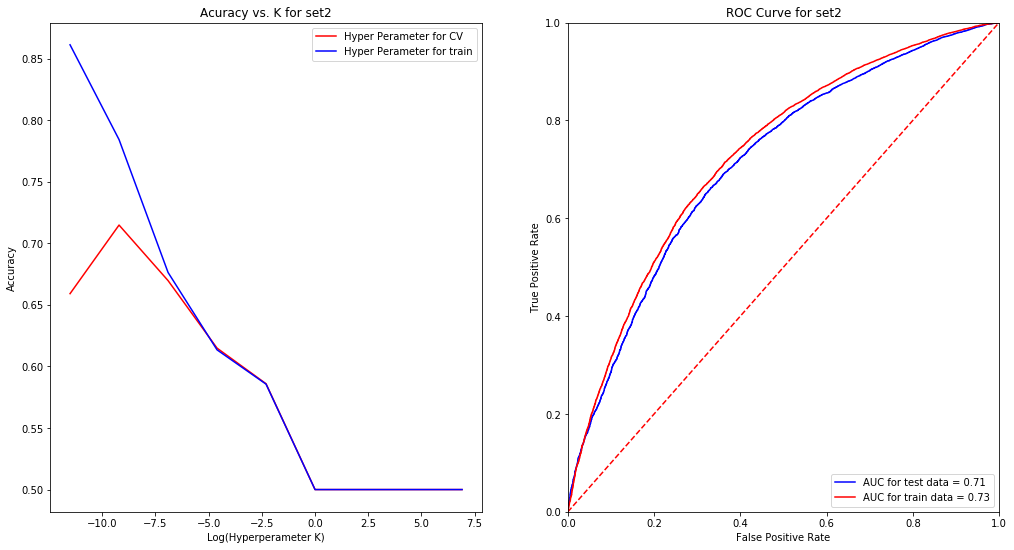

Traning Data


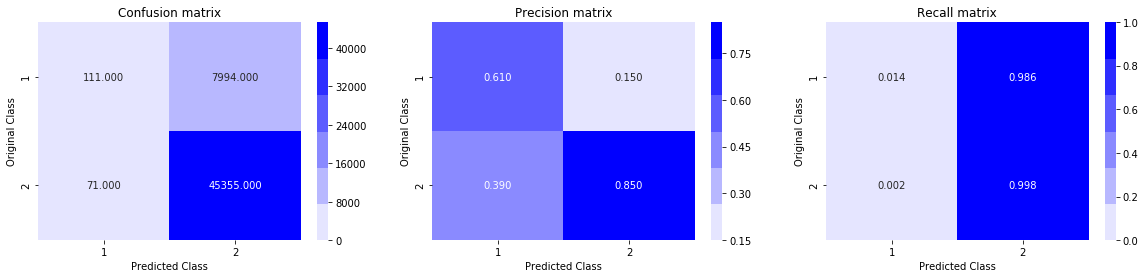

Test Data


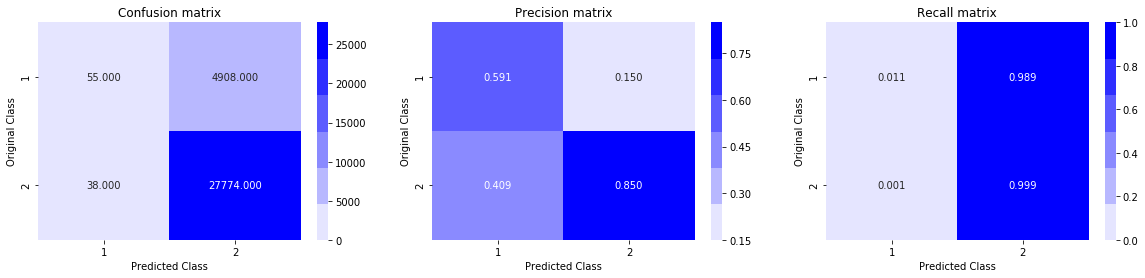

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set2')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set2')

# --------------------------------------------- Simple Cross validation ---------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l1', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set2_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set2_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set2_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l1', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set2_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set2_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set2_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set2 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# --------------------------------------------- Acuracy VS. K graph ---------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set2')
plt.legend(loc = 'upper right')

# --------------------------------------------- AUC Curve For Test data ---------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set2_test)
pred_test = SVM.predict(set2_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set2')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

------------------------------ With L2 Regularization ------------------------------
Max accuracy is for Alpha =  0.0001

****Test accuracy for set2 is 78%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



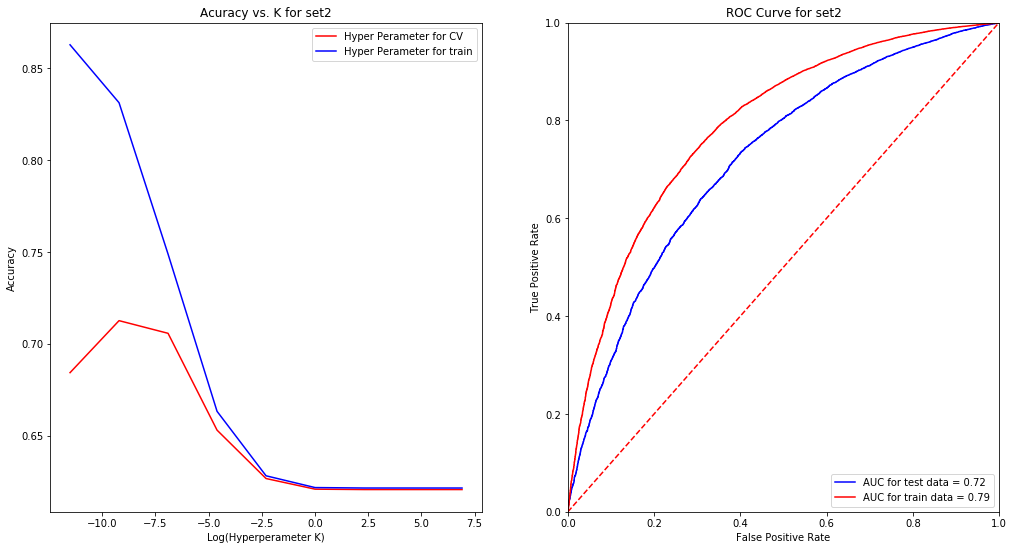

Traning Data


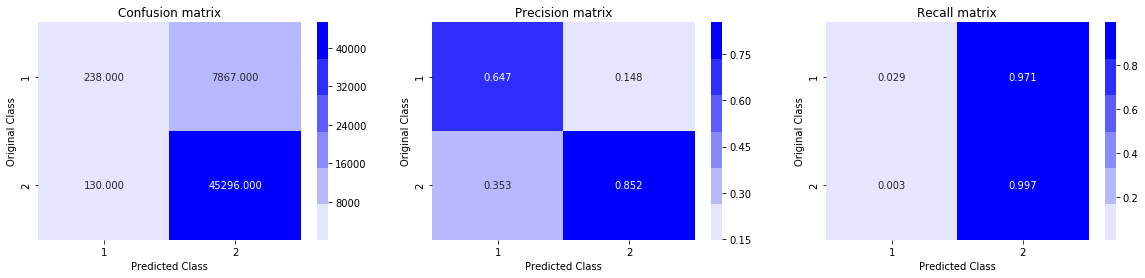

Test Data


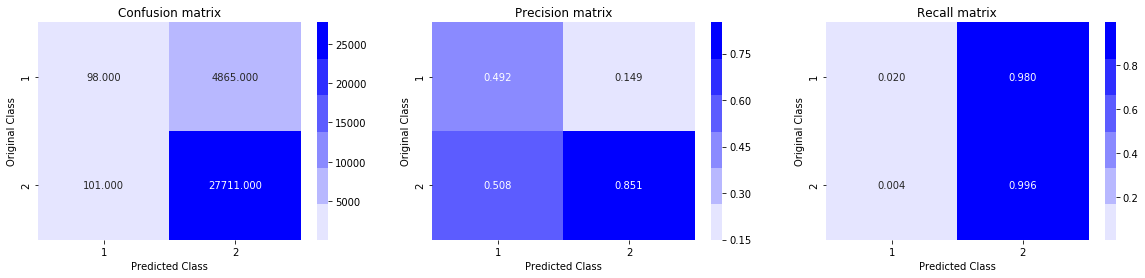

In [0]:
#======================================= L2 Regularization ===============================================

print('-'*30,'With L2 Regularization','-'*30)

#======================================= L2 Regularization ===============================================

# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set2')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set2')

# --------------------------------------- Simple Cross validation ------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l2', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set2_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set2_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set2_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l2', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set2_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set2_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set2_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set2 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# ---------------------------------------- Acuracy VS. K graph ---------------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set2')
plt.legend(loc = 'upper right')

# ----------------------------------------- AUC Curve For Test data -----------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set2_test)
pred_test = SVM.predict(set2_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set2')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

<b>Conclusion</b>
 : Not able to map true negative points. same as model 1

###SET3

Max accuracy is for Alpha =  0.0001

****Test accuracy for set3 is 72%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



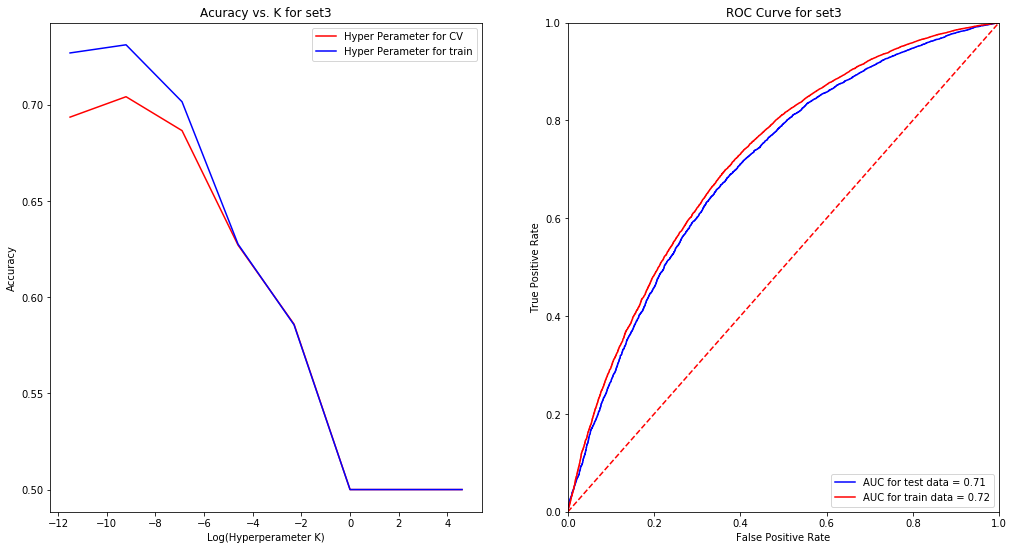

Traning Data


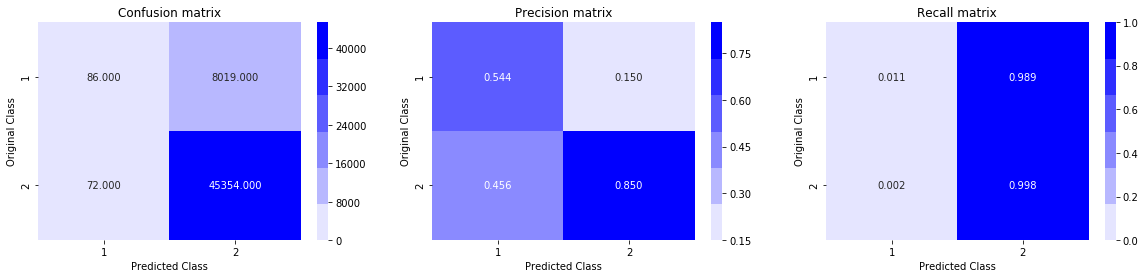

Test Data


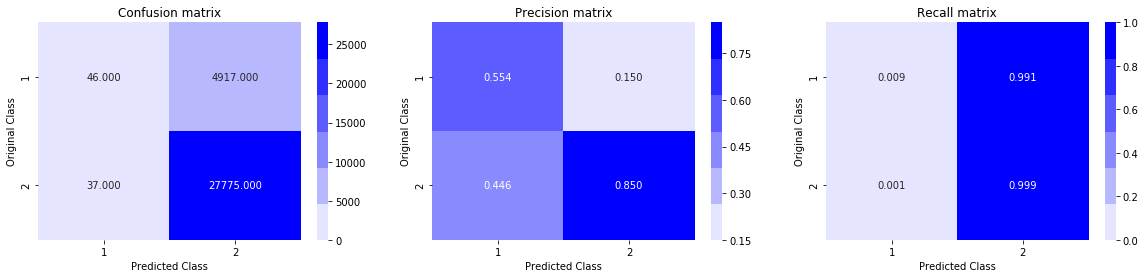

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set3')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set3')

# --------------------------------------------- Simple Cross validation ---------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l1', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set3_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set3_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set3_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l1', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set3_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set3_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set3_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set3 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# --------------------------------------------- Acuracy VS. K graph ---------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set3')
plt.legend(loc = 'upper right')

# --------------------------------------------- AUC Curve For Test data ---------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set3_test)
pred_test = SVM.predict(set3_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set3')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

------------------------------ With L2 Regularization ------------------------------
Max accuracy is for Alpha =  0.0001

****Test accuracy for set3 is 72%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



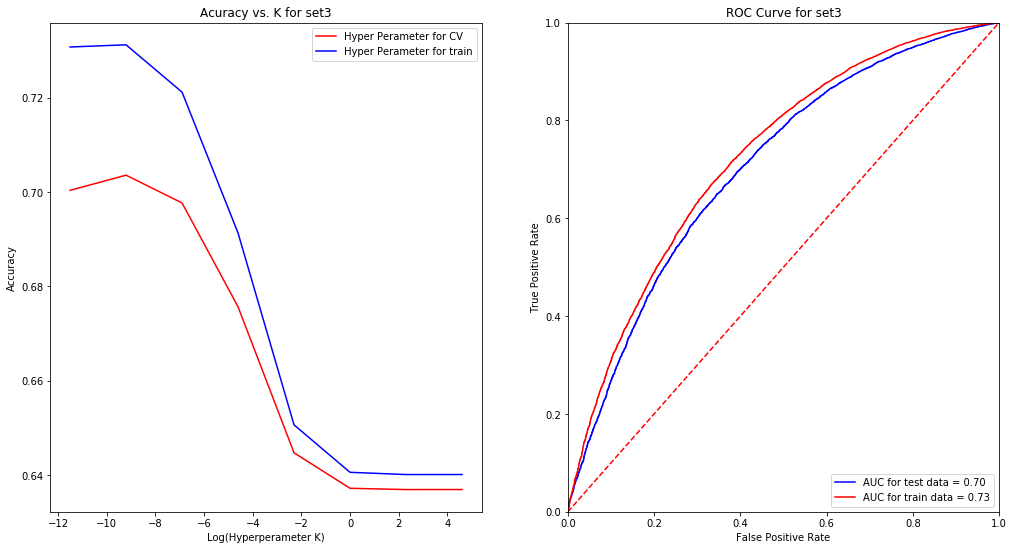

Traning Data


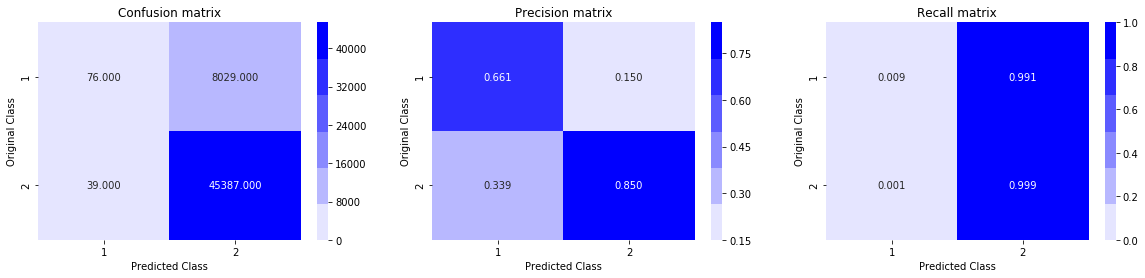

Test Data


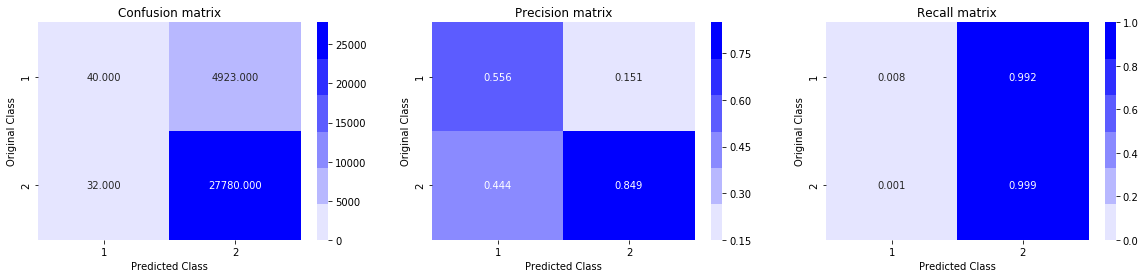

In [0]:
#======================================= L2 Regularization ===============================================

print('-'*30,'With L2 Regularization','-'*30)

#======================================= L2 Regularization ===============================================

# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set3')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set3')

# --------------------------------------- Simple Cross validation ------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l2', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set3_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set3_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set3_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l2', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set3_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set3_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set3_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set3 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# ---------------------------------------- Acuracy VS. K graph ---------------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set3')
plt.legend(loc = 'upper right')

# ----------------------------------------- AUC Curve For Test data -----------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set3_test)
pred_test = SVM.predict(set3_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set3')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

<b>Conclusion</b>
 :  Not able to predict any negative points.

###SET4

Max accuracy is for Alpha =  0.0001

****Test accuracy for set4 is 71%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



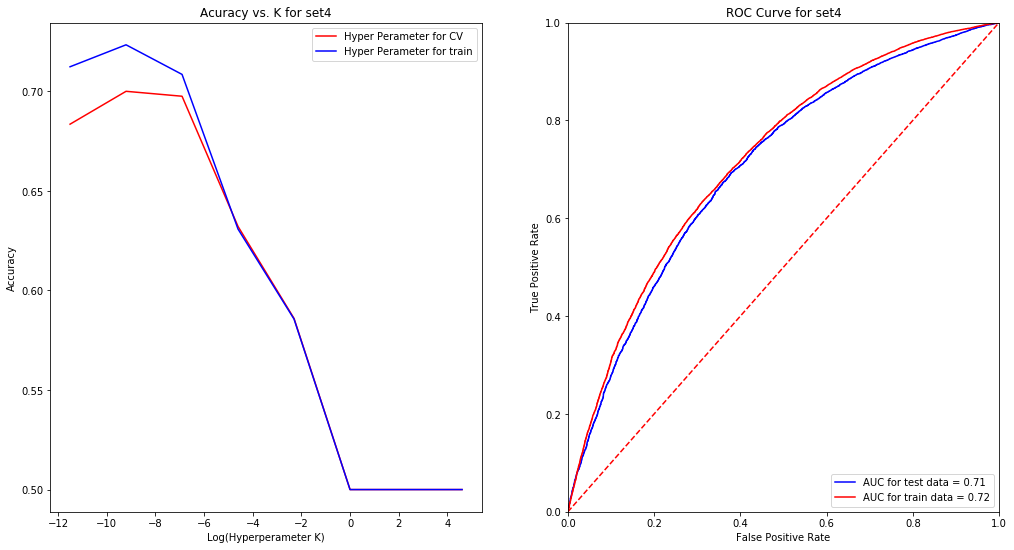

Traning Data


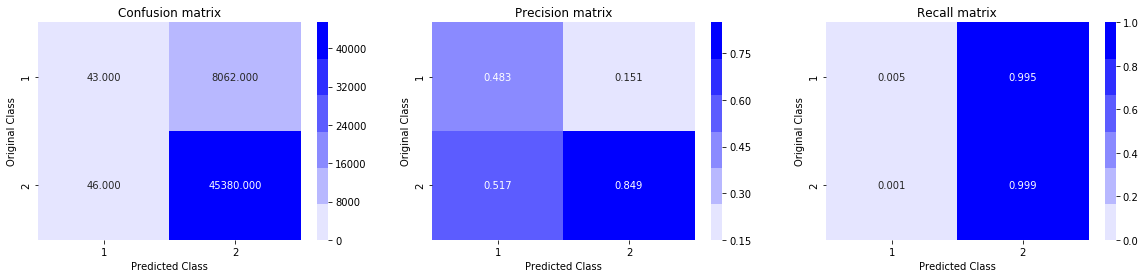

Test Data


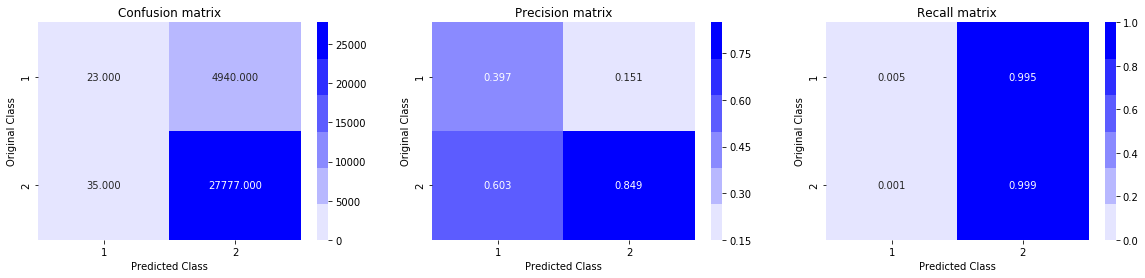

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set4')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set4')

# --------------------------------------------- Simple Cross validation ---------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l1', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set4_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set4_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set4_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l1', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set4_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set4_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set4_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set4 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# --------------------------------------------- Acuracy VS. K graph ---------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set4')
plt.legend(loc = 'upper right')

# --------------------------------------------- AUC Curve For Test data ---------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set4_test)
pred_test = SVM.predict(set4_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set4')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

------------------------------ With L2 Regularization ------------------------------
Max accuracy is for Alpha =  0.001

****Test accuracy for set4 is 71%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



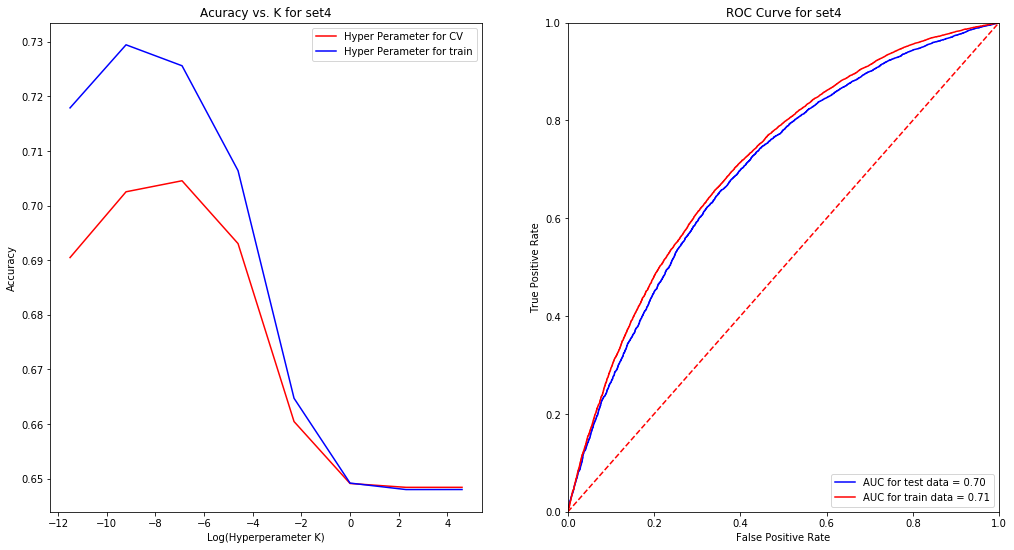

Traning Data


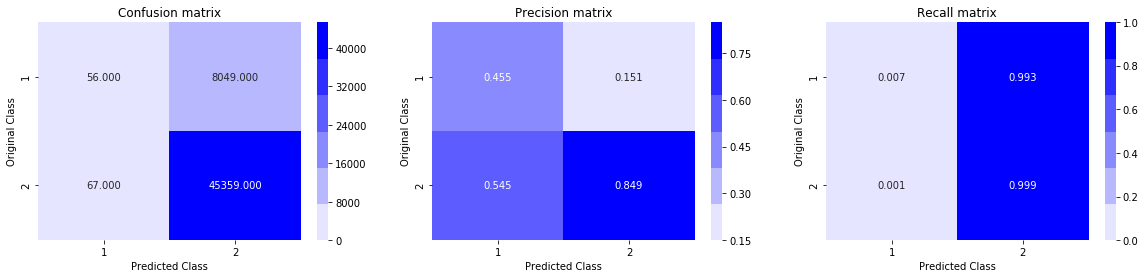

Test Data


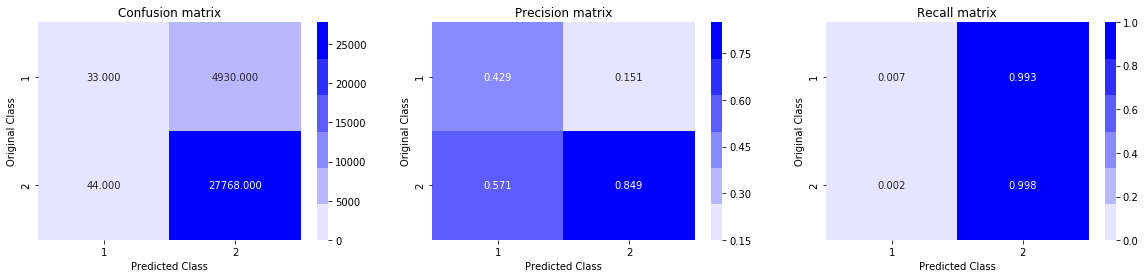

In [0]:
#======================================= L2 Regularization ===============================================

print('-'*30,'With L2 Regularization','-'*30)

#======================================= L2 Regularization ===============================================

# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set4')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set4')

# --------------------------------------- Simple Cross validation ------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l2', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set4_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set4_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set4_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l2', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set4_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set4_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set4_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set4 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# ---------------------------------------- Acuracy VS. K graph ---------------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set4')
plt.legend(loc = 'upper right')

# ----------------------------------------- AUC Curve For Test data -----------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set4_test)
pred_test = SVM.predict(set4_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set4')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

<b>Conclusion</b>
 :  Not able to predict negative points.

### <h2>2.5 SVM with added Features `Set 5` </h2>

Max accuracy is for Alpha =  1e-05

****Test accuracy for set5 is 48%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



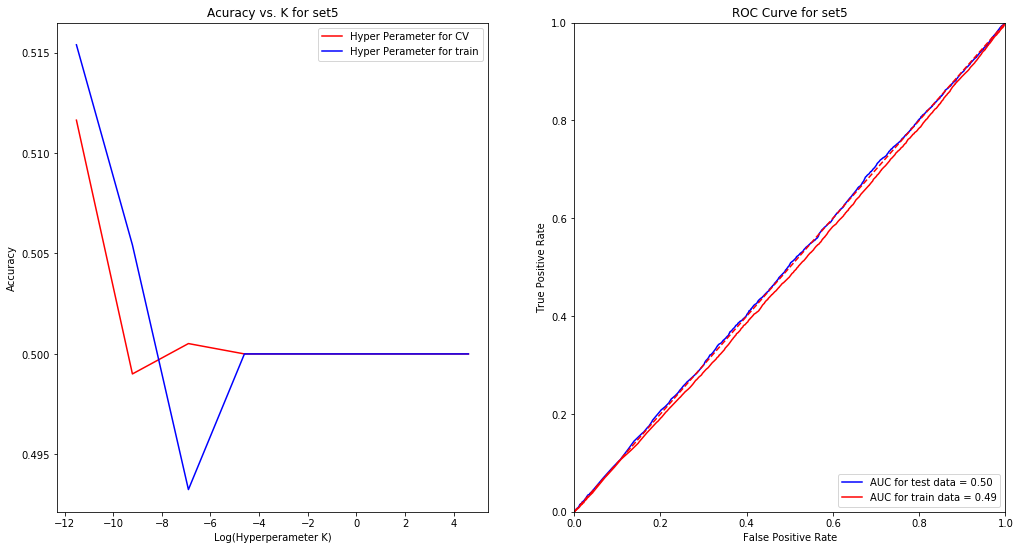

Traning Data


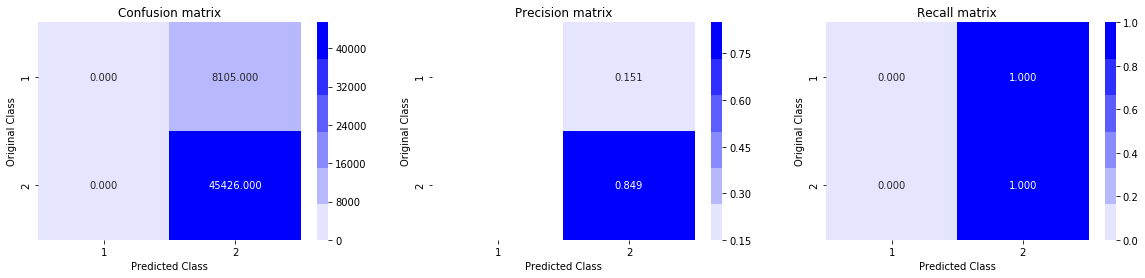

Test Data


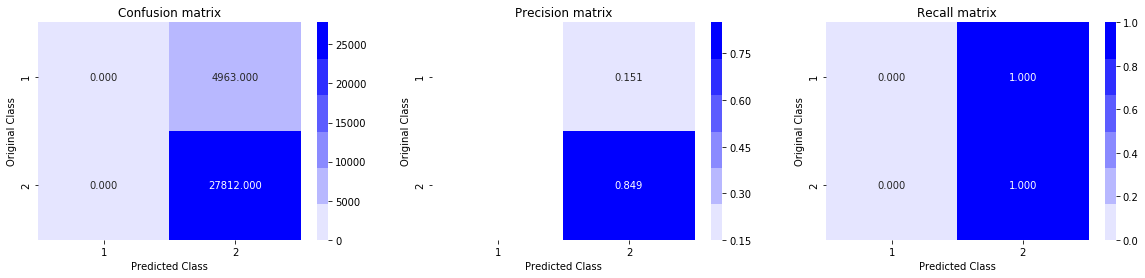

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set5')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set5')

# --------------------------------------- Simple Cross validation ------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l1', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set5_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set5_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set5_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l1', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set5_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set5_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set5_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set5 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# ---------------------------------------- Acuracy VS. K graph ---------------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set5')
plt.legend(loc = 'upper right')

# ----------------------------------------- AUC Curve For Test data -----------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set5_test)
pred_test = SVM.predict(set5_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set5')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

------------------------------ With L2 Regularization ------------------------------
Max accuracy is for Alpha =  1e-05

****Test accuracy for set5 is 50%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



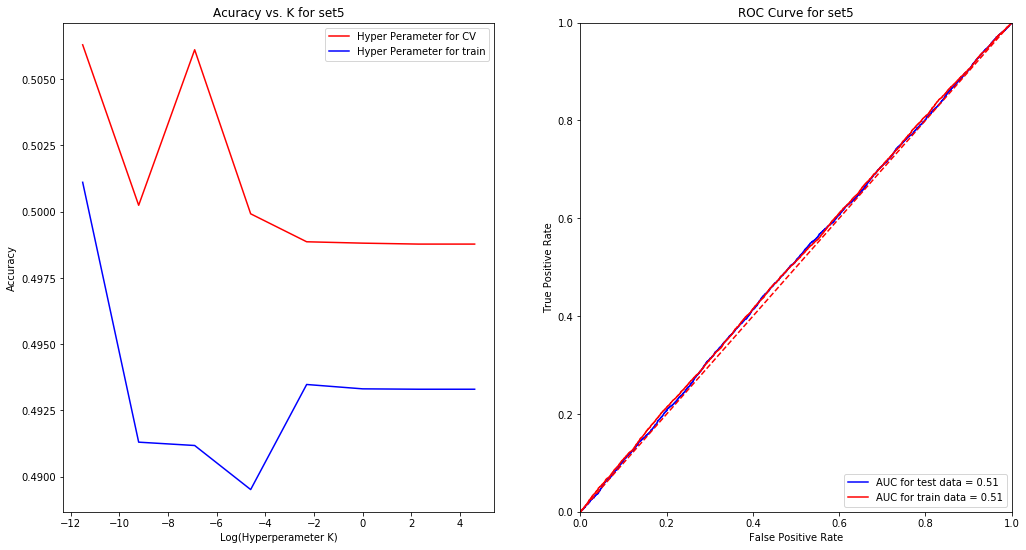

Traning Data


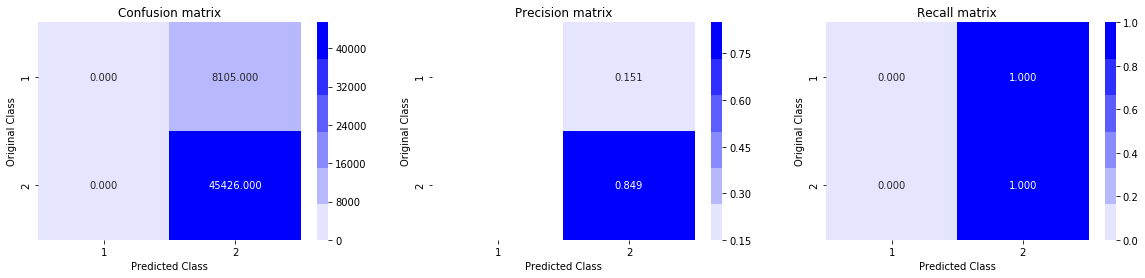

Test Data


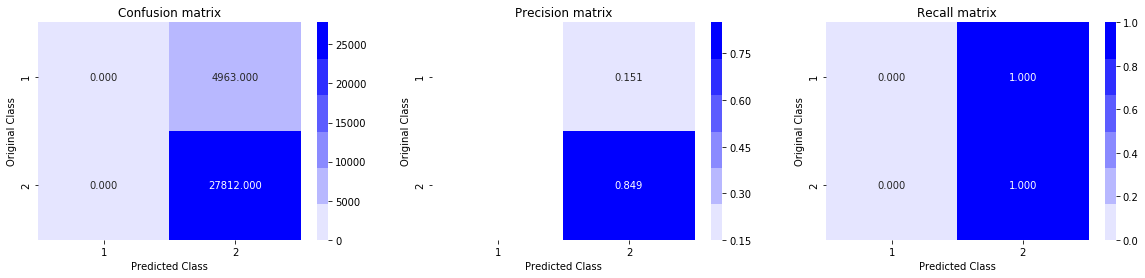

In [0]:
#======================================= L2 Regularization ===============================================

print('-'*30,'With L2 Regularization','-'*30)

#======================================= L2 Regularization ===============================================

# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

fig = plt.figure(1,figsize = (17,9))
fig1 = fig.add_subplot(121).set_title('Acuracy vs. K for set5')
fig2 = fig.add_subplot(122).set_title('ROC Curve for set5')

# --------------------------------------- Simple Cross validation ------------------------------------------

accuracy_of_CV_Datasets_on_different_values_of_alpha = {}
accuracy_of_Training_Datasets_on_different_values_of_alpha = {}
maximum_accuracy_still_found = 0

for i in [0.00001,0.0001,0.001,0.01,0.1,1,10,100]:
    SVM = CalibratedClassifierCV(SGDClassifier(loss = 'hinge',penalty = 'l2', alpha = i,class_weight="balanced",max_iter = 1000,random_state = 42))
    SVM.fit(set5_tr,approval_tr)
# --------------------------------------------- For Cross Validation ----------------------------------------------

    predicated_probability_values_of_CV_dataset_for_this_iteration = SVM.predict_proba(set5_cv)
    fpr_cv,tpr_cv,threshold = roc_curve(approval_cv,predicated_probability_values_of_CV_dataset_for_this_iteration[:,1])
    accuracy_value_of_CV_dataset_for_this_iteration = auc(fpr_cv,tpr_cv)

# --------------------------------------------- For Traning Data ---------------------------------------------------

    predicated_probability_value_of_Training_dataset_for_this_iteration = SVM.predict_proba(set5_tr)
    FPR_values_of_Traindata,TPR_values_of_Traindata,threshold = roc_curve(approval_tr,predicated_probability_value_of_Training_dataset_for_this_iteration[:,1])
    accuracy_value_of_Training_dataset_for_this_iteration = auc(FPR_values_of_Traindata,TPR_values_of_Traindata)
    
    accuracy_of_CV_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_CV_dataset_for_this_iteration
    accuracy_of_Training_Datasets_on_different_values_of_alpha[i] = accuracy_value_of_Training_dataset_for_this_iteration
    
    if accuracy_value_of_CV_dataset_for_this_iteration > maximum_accuracy_still_found:
      maximum_accuracy_still_found = accuracy_value_of_CV_dataset_for_this_iteration
      alpha_with_maximum_accuracy = i

print('Max accuracy is for Alpha = ',alpha_with_maximum_accuracy)

SVM = CalibratedClassifierCV(SGDClassifier(loss = 'log',penalty = 'l2', alpha = alpha_with_maximum_accuracy,max_iter = 1000,random_state = 42))
SVM.fit(set5_tr,approval_tr)

predicted_probability_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict_proba(set5_tr)
predicted_Y_values_of_Traindata_of_Max_accuracy_alpha = SVM.predict(set5_tr)
FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha,threshold = roc_curve(approval_tr,predicted_probability_values_of_Traindata_of_Max_accuracy_alpha[:,1])
accuracy_of_Traindata_with_Max_accuracy_alpha = auc(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha)

print('\n****Test accuracy for set5 is %d%%' % (accuracy_of_Traindata_with_Max_accuracy_alpha*100))

# ---------------------------------------- Acuracy VS. K graph ---------------------------------------------------

plt.subplot(121)
plt.plot([log(k) for k in list(accuracy_of_CV_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_CV_Datasets_on_different_values_of_alpha.values()),'r',label='Hyper Perameter for CV')
plt.plot([log(k) for k in list(accuracy_of_Training_Datasets_on_different_values_of_alpha.keys())],list(accuracy_of_Training_Datasets_on_different_values_of_alpha.values()),'b',label='Hyper Perameter for train')
plt.xlabel('Log(Hyperperameter K)')
plt.ylabel('Accuracy')
plt.title('Acuracy vs. K for set5')
plt.legend(loc = 'upper right')

# ----------------------------------------- AUC Curve For Test data -----------------------------------------------

probability_values_of_Testdata_with_Max_accuracy_alpha = SVM.predict_proba(set5_test)
pred_test = SVM.predict(set5_test)
FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha, threshold = roc_curve(approval_test, probability_values_of_Testdata_with_Max_accuracy_alpha[:, 1])
accuracy_of_Testdata_with_Max_accuracy_alpha = auc(FPR_values_of_Testdata_with_Max_accuracy_alpha, TPR_values_of_Testdata_with_Max_accuracy_alpha)

#------------------------------------------ Plotting Curve ------------------------------------------
plt.subplot(122)
plt.plot(FPR_values_of_Testdata_with_Max_accuracy_alpha,TPR_values_of_Testdata_with_Max_accuracy_alpha, 'b', label = 'AUC for test data = %0.2f' % accuracy_of_Testdata_with_Max_accuracy_alpha)
plt.plot(FPR_values_of_Traindata_with_Max_accuracy_alpha,TPR_values_of_Traindata_with_Max_accuracy_alpha, 'r', label = 'AUC for train data = %0.2f' % accuracy_of_Traindata_with_Max_accuracy_alpha)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for set5')
plt.show()

# -------------------------------------- Confusion Matrix -------------------------------------------------
print('Traning Data')
plot_confusion_matrix(approval_tr,predicted_Y_values_of_Traindata_of_Max_accuracy_alpha)
print('Test Data')
plot_confusion_matrix(approval_test,pred_test)

 <H2> Conclusion </H2>
No model is able to predict true negative.
 <br> i.e No support vectors found such that it can differentiate negative points from positive points. 

####<h1>3. Conclusion</h1>

In [0]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["DataSet", "Method","Hyper Perameter", "Test AUC","Train AUC"]

x.add_row(["Set1",'With L2 creteria',0.0001,61,62])
x.add_row(["Set1",'with L1 criteria',0.01,72,77])
x.add_row(["Set2",'With L2 creteria',0.0001,71,73])
x.add_row(["Set2",'with L1 criteria',0.0001,72,79])
x.add_row(["Set3",'With L2 creteria',0.0001,70,72])
x.add_row(["Set3",'with L1 criteria',0.0001,69,71])
x.add_row(["Set4",'With L2 creteria',0.001,66,67])
x.add_row(["Set4",'with L1 criteria',0.001,69,71])
x.add_row(["Set5",'With L2',0.0001,70,71])
x.add_row(["Set5",'with L1',0.0001,70,74])

print(x)

+---------+------------------+-----------------+----------+-----------+
| DataSet |      Method      | Hyper Perameter | Test AUC | Train AUC |
+---------+------------------+-----------------+----------+-----------+
|   Set1  | With L2 creteria |      0.0001     |    61    |     62    |
|   Set1  | with L1 criteria |       0.01      |    72    |     77    |
|   Set2  | With L2 creteria |      0.0001     |    71    |     73    |
|   Set2  | with L1 criteria |      0.0001     |    72    |     79    |
|   Set3  | With L2 creteria |      0.0001     |    70    |     72    |
|   Set3  | with L1 criteria |      0.0001     |    69    |     71    |
|   Set4  | With L2 creteria |      0.001      |    66    |     67    |
|   Set4  | with L1 criteria |      0.001      |    69    |     71    |
|   Set5  |     With L2      |      0.0001     |    70    |     71    |
|   Set5  |     with L1      |      0.0001     |    70    |     74    |
+---------+------------------+-----------------+----------+-----